# Flow Matching 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/flow_matching_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a flow-matching model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and likelihood estimation.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [1]:
# Load autoreload extension for development convenience
%load_ext autoreload
%autoreload 2

In [2]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [3]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples

In [4]:
# Set training and model restoration flags
overwrite_model = False
restore_model = False  # Use pretrained model if available
train_model = True  # Set to True to train from scratch

### Library Imports and JAX Backend Selection

In [5]:
# Import libraries and set JAX backend
import os
os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
# os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/flow_matching_2d_example_v2"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [7]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45

    return data

In [ ]:
data = make_boxes_jax(jax.random.PRNGKey(0), 500_000)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data)[..., None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
)

# we define a multiprocess data loader with automatic performance tuning
performance_config = grain.experimental.pick_performance_config(
            ds=train_dataset_grain,
            ram_budget_mb=1024 * 4,
            max_workers=None,
            max_buffer_size=None,
        )

dataset_batched = train_dataset_grain.batch(512).mp_prefetch(
            performance_config.multiprocessing_options
        )

train_iter = iter(train_dataset_grain)

data_val = make_boxes_jax(jax.random.PRNGKey(1), 1000)
val_dataset_grain = jnp.array(data_val[...,None])

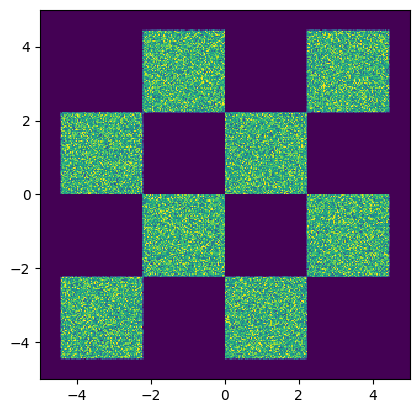

In [9]:
# Visualize the generated data distribution
samples = np.array(data)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the flow-matching model.

In [10]:
from gensbi.recipes import Flux1JointFlowPipeline
from gensbi.models.flux1joint import  Flux1JointParams

/home/zaldivar/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
params = Flux1JointParams(
            in_channels=1,
            vec_in_dim=None,
            mlp_ratio=3.0,
            num_heads=2,
            depth_single_blocks=8,
            axes_dim=[2],
            condition_dim=[2],
            qkv_bias=True,
            rngs=nnx.Rngs(0),
            joint_dim=2,
            theta=10,
            guidance_embed=False,
            param_dtype=jnp.float32,
        )

In [12]:
training_config = Flux1JointFlowPipeline._get_default_training_config()

In [13]:
training_config["checkpoint_dir"] = checkpoint_dir

In [14]:
pipeline = Flux1JointFlowPipeline(
        train_dataset_grain,
        val_dataset_grain,
        2,
        0,
        params=params,
        training_config=training_config,
    )

In [15]:
pipeline.train(nnx.Rngs(0), nsteps=10_000)

100%|██████████| 10000/10000 [05:02<00:00, 33.06it/s, counter=2, loss=2.8967, ratio=1.2384, val_loss=3.5873]


Saved model to checkpoint


([Array(5.1747336, dtype=float32),
  Array(5.6925864, dtype=float32),
  Array(5.2300935, dtype=float32),
  Array(3.3343031, dtype=float32),
  Array(2.8990452, dtype=float32),
  Array(2.8283248, dtype=float32),
  Array(4.282297, dtype=float32),
  Array(4.0311317, dtype=float32),
  Array(4.4975824, dtype=float32),
  Array(2.9453835, dtype=float32),
  Array(3.3375385, dtype=float32),
  Array(3.9916754, dtype=float32),
  Array(6.785972, dtype=float32),
  Array(4.3832955, dtype=float32),
  Array(4.549111, dtype=float32),
  Array(2.9244664, dtype=float32),
  Array(4.015344, dtype=float32),
  Array(3.4267323, dtype=float32),
  Array(3.9812303, dtype=float32),
  Array(5.40539, dtype=float32),
  Array(4.7617607, dtype=float32),
  Array(3.35656, dtype=float32),
  Array(4.035029, dtype=float32),
  Array(5.796159, dtype=float32),
  Array(3.6562123, dtype=float32),
  Array(3.0929887, dtype=float32),
  Array(4.0527644, dtype=float32),
  Array(4.052062, dtype=float32),
  Array(4.1926546, dtype=float3

## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [16]:
# Save the trained model to checkpoint (if training was performed)
if train_model:
    # pass
    pipeline.save_model(2)

Saved model to checkpoint


## 5. Sampling from the Model

In this section, we sample trajectories from the trained flow-matching model and visualize the results at different time steps.

### sample the model

In [17]:
# Sample trajectories from the model using ODE solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

# batch_size = 500_000  # batch size
T = jnp.linspace(0,1,10)  # sample times

# x_init = p0.sample(jax.random.PRNGKey(0), (batch_size, ))  # initial conditions
# solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
# sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)
sol = pipeline.sample(jax.random.PRNGKey(0), jnp.zeros((0,)), 500_000, time_grid=T)

In [ ]:
# Visualize the sampled trajectories at different time steps
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
plt.show()

## 6. Marginal distribution

We visualize the marginal distributions.

In [ ]:
# Import plotting utility for marginals
from gensbi.utils.plotting import plot_marginals

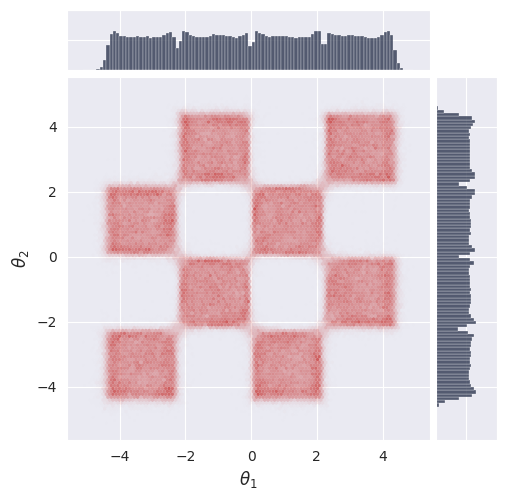

In [ ]:
# Plot the marginal distribution of the final samples
plot_marginals(sol[-1], plot_levels=False, gridsize=100, backend="seaborn")
plt.show()